In [8]:
from aurora.client import ElasticClient
client = ElasticClient()

In [19]:
import urllib.request
from PIL import Image
import logging
from time import sleep
import os
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
from aurora.kiruna import k_calculator
import numpy
print('start')

logging.basicConfig(filename='Q_logs.log',  filemode='a', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
train_data=[]

def generate_train_data(test_q, test_q_prev, kiruna_Q):
    
    if 'max_x' in test_q.keys():
        xAmp_15=test_q['max_x'] - test_q['min_x']
        yAmp_15=test_q['max_y'] - test_q['min_y']
    elif 'max_x' in test_q_prev.keys():
        xAmp_15=test_q_prev['max_x'] - test_q_prev['min_x']
        yAmp_15=test_q_prev['max_y'] - test_q_prev['min_y']
    else:
        xAmp_15=0
        yAmp_15=0
    xQ_15 = kindex_calc.get_K_index(xAmp_15)
    yQ_15 = kindex_calc.get_K_index(yAmp_15)

    if 'max_x' in test_q_prev.keys() and 'max_x' in test_q.keys():
        xAmp_30=max(test_q['max_x'], test_q_prev['max_x']) - min(test_q['min_x'], test_q_prev['min_x'])
        yAmp_30=max(test_q['max_y'], test_q_prev['max_y']) - min(test_q['min_y'], test_q_prev['min_y'])
        xQ_30 = kindex_calc.get_K_index(xAmp_30)
        yQ_30 = kindex_calc.get_K_index(yAmp_30)
        #print([test_q['max_x'], test_q_prev['max_x']])
        #print([test_q['min_x'], test_q_prev['min_x']])
        return ["{:.2f}".format(xAmp_30), 
                "{:.2f}".format(yAmp_30),
                "{:.2f}".format(xAmp_15),
                "{:.2f}".format(yAmp_15),
                str(xQ_30),
                str(xQ_15),
                str(yQ_15),
                str(kiruna_Q)]        
    else:        
        return ["{:.2f}".format(xAmp_15), 
                "{:.2f}".format(yAmp_15),
                "{:.2f}".format(xAmp_15),
                "{:.2f}".format(yAmp_15),
                str(xQ_15),
                str(xQ_15),
                str(yQ_15),
                str(kiruna_Q)]        


    
def analising(filename, elastic_q):
    global train_data
    #img = urllib.request.urlopen(
         #   "http://www2.irf.se/maggraphs/preliminary_k_index_last_24.png", timeout=30).read()
    #out = open("K&Q index.png", "wb")
    #out.write(img)
    #out.close()

    image = Image.open(filename)
    pix = image.load()
    start_x = 670
    end_x = 1185
    x = 1185
    y_1 = 145
    y_2 = 131
    y_3 = 118
    y_4 = 105
    y_5 = 91
    y_6 = 78
    y_7 = 65
    y_8 = 51
    y_9 = 38
    sample_color = str((255, 255, 255))
    mismatches={0:0,1:0}
    q=0
    train_q = []
    predict_q1 = []
    for n in list(range(0,95)):
        prev_q = q
        x = 670 + int(n * (end_x-start_x) / 94)
        
        if str((pix[x-1, y_9]))  != sample_color or str((pix[x+1, y_9]))  != sample_color or str((pix[x, y_9])) != sample_color:
            q = 9
        elif str((pix[x-1, y_8]))  != sample_color or str((pix[x+1, y_8]))  != sample_color or str((pix[x, y_8])) != sample_color:
            q = 8
        elif str((pix[x-1, y_7]))  != sample_color or str((pix[x+1, y_7]))  != sample_color or str((pix[x, y_7])) != sample_color:
            q = 7
        elif str((pix[x-1, y_6]))  != sample_color or str((pix[x+1, y_6]))  != sample_color or str((pix[x, y_6])) != sample_color:
            q = 6
        elif str((pix[x-1, y_5]))  != sample_color or str((pix[x+1, y_5]))  != sample_color or str((pix[x, y_5])) != sample_color:
            q = 5
        elif str((pix[x-1, y_4]))  != sample_color or str((pix[x+1, y_4]))  != sample_color or str((pix[x, y_4])) != sample_color:
            q = 4
        elif str((pix[x-1, y_3]))  != sample_color or str((pix[x+1, y_3]))  != sample_color or str((pix[x, y_3])) != sample_color:
            q = 3
        elif str((pix[x-1, y_2]))  != sample_color or str((pix[x+1, y_2]))  != sample_color or str((pix[x, y_2])) != sample_color:
            q = 2
        elif str((pix[x-1, y_1]))  != sample_color or str((pix[x+1, y_1]))  != sample_color or str((pix[x, y_1])) != sample_color:
            q = 1
        else:
            q = 0
        if n<len(elastic_q):
            if n>0:
                test_q_value=kindex_calc.calculate_q_4(elastic_q[n], elastic_q[n-1])
                train_data.append(generate_train_data(elastic_q[n], elastic_q[n-1],q))
            else:
                test_q_value=kindex_calc.calculate_q_4(elastic_q[n], elastic_q[n])
                train_data.append(generate_train_data(elastic_q[n], elastic_q[n-1],q))
            train_q.append(q)            
            predict_q1.append(test_q_value)
            if (test_q_value!=q and test_q_value!=prev_q):
                mismatches[0]+=1/len(elastic_q)
#            test_q_value=kindex_calc.calculate_q_3(predict_q[n], min(predict_q[0]['min_x'],predict_q[40]['min_x']),
 #                                      min(predict_q[0]['min_y'],predict_q[40]['min_y']))
            
     #       print("n: "+ str(n)+ "  q = " + str(q) + " test_q = "+str(test_q_value))
  #          if (test_q_value!=q and test_q_value!=prev_q):
   #             mismatches[1]+=1/len(predict_q)

    
    print("train_data:"+str(len(train_data))+" total mismatches: "+ str(mismatches) + " from " + str(len(predict_q)))
    return train_q, predict_q1

def get_image_data_range(filename, delta):
    date=filename.split("last_24_",1)[1]
    date_format_str = '%m-%d_%H%M'            
    start = datetime.strptime(date.split(".png",1)[0], date_format_str)
    end = start + timedelta(1) #relativedelta(day=1)
    return start.strftime('2021-%m-%dT%H:%M:00.000Z'), end.strftime('2021-%m-%dT%H:%M:00.000Z')
    
#while True:
#    try:
def count_missing_data(start_ts, elastic_start_ts):
    date_format_str = '%Y-%m-%dT%H:%M:%S.%fZ'
    start = datetime.strptime(start_ts, date_format_str)
    end =  datetime.strptime(elastic_start_ts, date_format_str)
    diff_in_minutes = (end-start).total_seconds() / 60
    return diff_in_minutes / 15

basepath=os.path.join( "C:\\", "Projects", "aurora","maggraphs","test")

#filename=
#filename=
#filename=
#filename=
# ["preliminary_k_index_last_24_11_21_0730.png"]  - two peaks of q=5
#for filename in os.listdir(basepath):
files=[      
      "preliminary_k_index_last_24_11-08_0645.png",
      "preliminary_k_index_last_24_11-14_0730.png",
      "preliminary_k_index_last_24_11-15_0800.png",
      "preliminary_k_index_last_24_11-20_1030.png",
      "preliminary_k_index_last_24_11-21_0730.png",
      "preliminary_k_index_last_24_12-03_1530.png",
      "preliminary_k_index_last_24_12-05_0900.png",
      "preliminary_k_index_last_24_12-10_2015.png"]
#test data
#files=["preliminary_k_index_last_24_12-02_2130.png"]
#files=["preliminary_k_index_last_24_11-21_2230.png"]
files=["preliminary_k_index_last_24_12-20_0800.png"]
#train_data.append([])
for filename in files:
#for filename in ["preliminary_k_index_last_24_12-02_2130.png"]:
    train_q=[]
    predict_q=[]
    if os.path.isfile(os.path.join(basepath, filename)):
        print(filename)
 
    start_ts,end_ts=get_image_data_range(filename, 0)
    elastic_data = client.mean_comp("mag-logback", start_ts, end_ts)
    need_append = count_missing_data(start_ts, elastic_data[0]['ts'])
    
    if need_append>0:
        print('missing records: ' + str(need_append))
        new_array = []
        num=int(need_append)
        for i in range(0,num):
            new_array.append({'min_x':elastic_data[0]['min_x'],'min_y':elastic_data[0]['min_y']})
        new_array.extend(elastic_data)
        elastic_data = new_array
    train_q, predict_q = analising(os.path.join(basepath, filename), elastic_data)    
    print("elastic size:" + str(len(elastic_data)) +" need append: "+ str(need_append))
      
a = numpy.asarray(train_data)
numpy.savetxt("test_data.csv",  a, fmt="%s",  delimiter=",", header="xAmp_30,yAmp_30,xAmp_15,yAmp_15,xQ_30,xQ_15,yQ_15,kiruna_Q")
print()

start
preliminary_k_index_last_24_12-20_0800.png
{
  "query": {
    "range": {
      "@timestamp": {
        "gte": "2021-12-20T08:00:00.000Z",
        "lte": "2021-12-21T08:00:00.000Z"
      }
    }
  },
  "runtime_mappings": {
    "f.calc": {
      "type": "double",
      "script": "emit(doc['xComp'].value+doc['yComp'].value/5)"
    }
  },
  "size": 0,
  "aggs": {
    "avg_x": {
      "avg": {
        "field": "xComp"
      }
    },
    "avg_y": {
      "avg": {
        "field": "yComp"
      }
    },
    "avg_z": {
      "avg": {
        "field": "zComp"
      }
    },
    "calc": {
      "date_histogram": {
        "field": "@timestamp",
        "fixed_interval": "15m"
      },
      "aggs": {
        "max_x": {
          "max": {
            "field": "xComp"
          }
        },
        "min_x": {
          "min": {
            "field": "xComp"
          }
        },
        "max_y": {
          "max": {
            "field": "yComp"
          }
        },
        "min_y": {
    

In [17]:
import pandas as pd
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
    

def encode_labels(df):
    le = preprocessing.LabelEncoder()
    for column in df.columns:
        if df[column].dtype == type(object):
            df[column] = le.fit_transform(df[column])
    return df


training_df = pd.read_csv('files/train_data.csv')
test_df = pd.read_csv('files/test_data.csv')

approved = training_df["kiruna_Q"]
training_df = training_df.drop('kiruna_Q', axis=1)

q_kiruna = test_df["kiruna_Q"]
test_df = test_df.drop('kiruna_Q', axis=1)

training_df = encode_labels(training_df)
test_df = encode_labels(test_df)


model = DecisionTreeClassifier().fit(training_df, approved)
y_pred = model.predict(test_df)
res = model.predict_proba(test_df)
predicted_df = pd.Series(res[:,1])

predicted_df.to_csv("files/prediction_q_logistic_tree_rgr.csv", index=False)
sum_q=0
diff=0
for idx, predicted_value in enumerate(y_pred):
    #sum_q+=q_kiruna[idx]
    sum_q+=1
    if (idx+1<len(q_kiruna)) and predicted_value!= q_kiruna[idx] and predicted_value!= q_kiruna[idx+1]:
        #diff+=abs(predicted_value-q_kiruna[idx])
        diff+=1
        print(str(idx) +" predicted:" +str(predicted_value) + " kiruna:"+str(q_kiruna[idx]))
print(diff/sum_q)
print(len(y_pred))
# prev: 0.2127659574468085
# new: 0.14736842105263157

1 predicted:2 kiruna:1
3 predicted:5 kiruna:2
6 predicted:1 kiruna:2
13 predicted:1 kiruna:2
24 predicted:0 kiruna:2
39 predicted:2 kiruna:3
40 predicted:4 kiruna:3
42 predicted:0 kiruna:1
45 predicted:0 kiruna:3
51 predicted:0 kiruna:3
57 predicted:2 kiruna:3
59 predicted:3 kiruna:2
60 predicted:1 kiruna:4
62 predicted:4 kiruna:5
64 predicted:5 kiruna:4
66 predicted:3 kiruna:2
68 predicted:2 kiruna:3
76 predicted:3 kiruna:2
77 predicted:2 kiruna:1
81 predicted:0 kiruna:1
83 predicted:2 kiruna:1
87 predicted:2 kiruna:0
89 predicted:0 kiruna:2
91 predicted:2 kiruna:1
0.25263157894736843
95


In [1]:
from aurora.kiruna.mag_client import MagWatcher
import time
#https://github.com/ilteoood/SiteAlert-Python/blob/master/SiteAlert.py
#telegram: https://github.com/alexander-akhmetov/python-telegram/blob/master/examples/send_message.py
watcher=MagWatcher(freq = 60)
watcher.service()
while True:
    try:       
        print(watcher.calculate_Q())
        time.sleep(30)
    
    except Exception as e:
        print(e)
        time.sleep(5)


init current_ts_utc: 2021-12-15 20:53:01.039214
start
0:40:00.001057
new lines 0
200 OK 0
0
start
0:40:05.247654
new lines 2351
206 Partial Content 86580
2
2
start
0:01:54.553568
new lines 0
206 Partial Content 4104
2
2
start
0:02:54.722819
new lines 119
206 Partial Content 6264
2
2
start
0:01:55.889229
new lines 0
206 Partial Content 4140
2
2
start
0:02:56.114998
new lines 122
206 Partial Content 6336
2
2
start
0:01:54.302351
new lines 0
206 Partial Content 4104
2
2
start
0:02:54.473553
new lines 123
206 Partial Content 6264
2
2
start
0:01:51.639600
new lines 0
206 Partial Content 3996
2
2
start
0:02:51.820267
new lines 116
206 Partial Content 6156
2
2
start
0:01:56.034581
new lines 0
206 Partial Content 4176
2
2
start
0:02:56.205619
new lines 120
206 Partial Content 6336
2
2
start
0:01:56.358708
new lines 0
206 Partial Content 4176
2
2
start
0:02:56.784339
new lines 124
206 Partial Content 6336
2
2
start
0:01:52.950879
new lines 0
206 Partial Content 4032
2
2
start
0:02:53.115146
new

KeyboardInterrupt: 

95
0     2
1     1
2     1
3     2
4     1
     ..
90    1
91    1
92    1
93    1
94    1
Name: kiruna_Q, Length: 95, dtype: int64
95
[1, 1, 1, 2, 2, 2, 1, 2, 3, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 2, 1, 1, 2, 2, 2, 2, 3, 4, 3, 3, 2, 3, 3, 3, 2, 2, 2, 1, 2, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 4, 3, 5, 5.0, 5, 5.0, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1.0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
95
[2 2 1 5 2 2 1 2 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1 1 0 1 3 2 3 2 2 1 1 1 2 2 2
 2 4 2 4 3 0 3 3 0 2 2 2 2 2 0 3 3 2 3 2 2 3 3 1 4 4 5 5 2 3 3 2 3 3 3 3 3
 3 2 3 2 1 1 1 0 1 2 1 1 1 2 0 0 1 2 1 1 1]


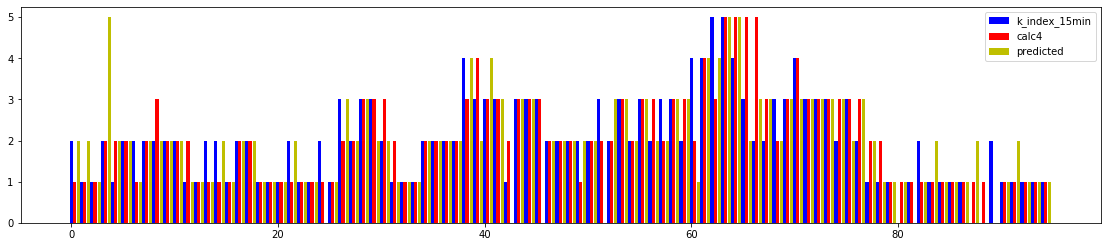

In [18]:
import numpy as np
import matplotlib.pyplot as plt
start_point = 0
print(len(q_kiruna))
print(q_kiruna[start_point:len(train_q)])
print(len(predict_q))
print(predict_q)
print(len(y_pred[start_point:len(predict_q)]))
print(y_pred)

data = [q_kiruna[start_point:len(predict_q)],
predict_q[start_point:len(predict_q)],
       y_pred[start_point:len(predict_q)]]
X = np.arange(start_point,len(predict_q))
fig = plt.figure()
fig.set_size_inches(15, 3)
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, data[0], color = 'b', width = 0.3)
ax.bar(X + 0.3, data[1], color = 'r', width = 0.3)
ax.bar(X + 0.7, data[2], color = 'y', width = 0.3)
ax.legend(labels=['k_index_15min', 'calc4', 'predicted'])
#ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)